## DATA PROCESSING

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras import backend

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [5]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    r"Rice Leaf Disease Images",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5932 files belonging to 4 classes.


In [6]:
class_names= dataset.class_names
print(class_names)
len(dataset)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


186

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 2 1 3 3 2 0 3 2 0 3 2 3 3 3 1 3 1 0 0 1 3 3 0 2 0 1 3 1 2]


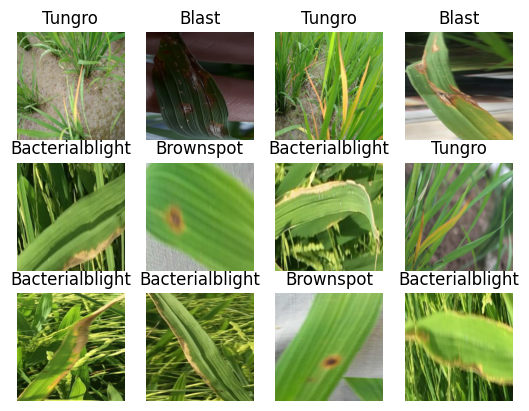

In [8]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## DATA SPLITTING

***Function to Split Dataset***

Dataset should be bifurcated into 3 subsets, namely:


Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model


In [9]:
len(dataset)

186

In [10]:
train_size=0.8
len(dataset)*train_size


148.8

In [11]:
train_ds = dataset.take(148)
len(train_ds)

148

In [12]:
test_ds=dataset.skip(148)
len(test_ds)

38

In [13]:
val_size= 0.1
len(dataset)*val_size

18.6

In [14]:
val_ds=test_ds.take(18)
len(val_ds)

18

In [15]:
test_ds=test_ds.skip(18)
len(test_ds)

20

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds,test_ds= get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

148
18
20


Cache, Shuffle, and Prefetch the Dataset

In [17]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Creating a Layer for Resizing and Normalization

In [18]:
from tensorflow.keras import layers
import tensorflow as tf

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

## DATA AUGMENTATION

***Data Augmentation***

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [19]:
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


## MODEL BUILDING

In [21]:
from tensorflow.keras import layers, models

# Constants
IMAGE_SIZE = 256  # Input image dimensions
CHANNELS = 3      # Number of color channels (RGB)
n_classes = 4     # Number of classes

# Define the model
model = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Define input shape here
    layers.Rescaling(1./255),  # Normalize pixel values
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
    layers.MaxPooling2D((2, 2)),  # Pooling layer
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),  # Flatten feature maps into a single vector
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dense(n_classes, activation='softmax'),  # Output layer
])

# Summarize the model
model.summary()


C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,956 (1.06 MB)

 Trainable params: 277,956 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

## COMPILING AND TRAINING PHASE

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,     
    verbose=1,
    epochs=20,
)

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4721 - loss: 1.1318

## Evaluating Model

In [2]:
train_loss, train_acc = model.evaluate(train_ds)
print('Training accuracy:', train_acc)


val_loss, val_acc = model.evaluate(val_ds)
print('Validation accuracy:', val_acc)

NameError: name 'model' is not defined

## Saving Model

In [ ]:
model.save('trained_plant_disease_model.keras')
history.history #Return Dictionary of history

#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(history.history,f)
print(history.history.keys())

In [23]:
scores = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9989 - loss: 0.0068


In [24]:
scores
print(f"Test Accuracy: {scores[1]*100}%")


Test Accuracy: 99.6874988079071%


In [25]:
history


In [26]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 148}

In [27]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [28]:
type(history.history['loss'])

list

In [29]:
len(history.history['loss'])

20

In [30]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0388973951339722,
 0.7104164361953735,
 0.4664473831653595,
 0.33489271998405457,
 0.25468605756759644]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

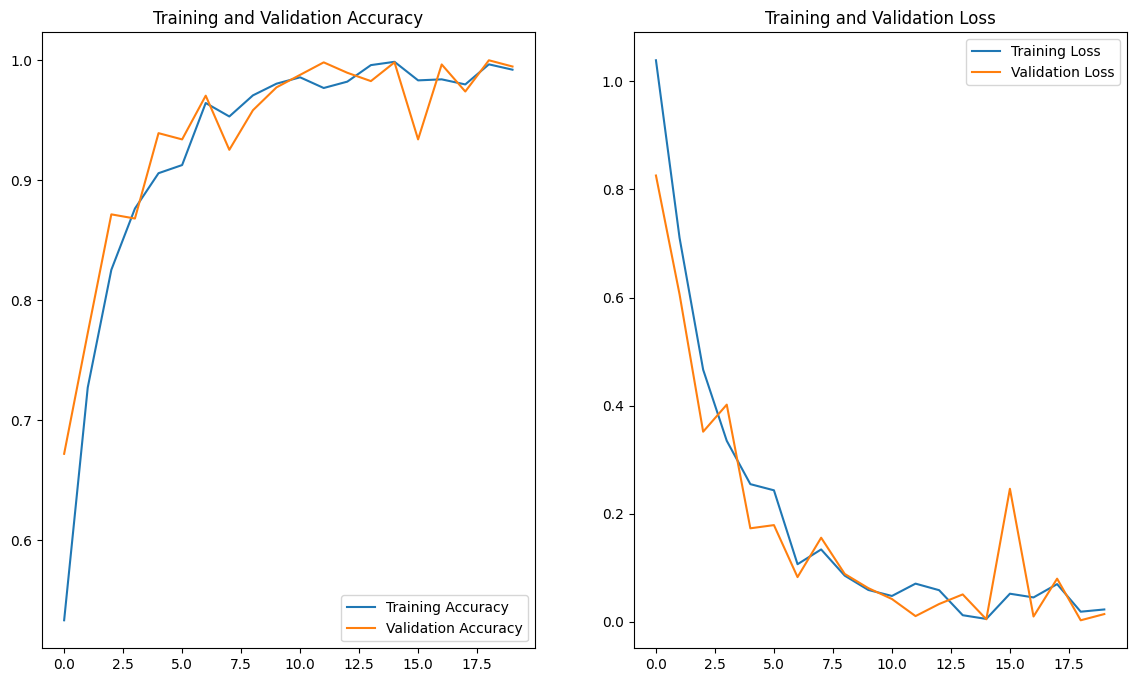

In [32]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Blast
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
predicted label: Blast


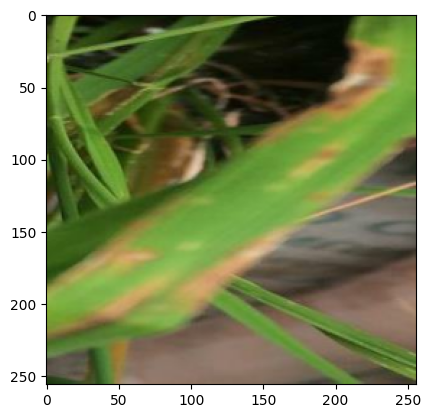

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


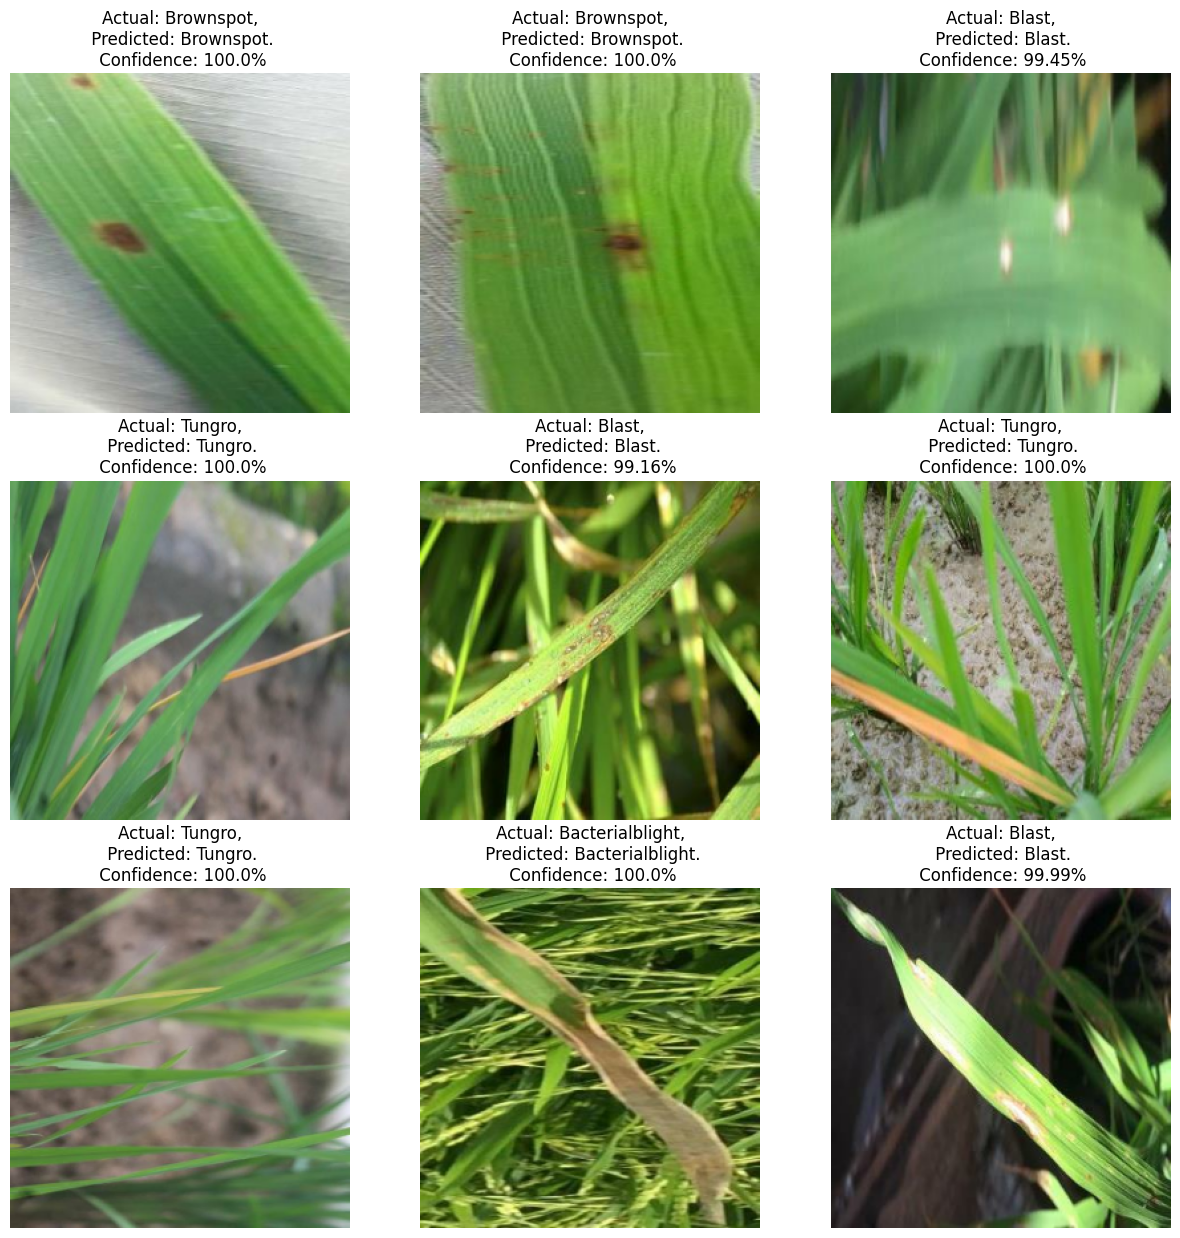

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
import os

# Directory to save models
directory = '../models'
if not os.path.exists(directory):
    os.makedirs(directory)

# Determine the next version of the model
model_version = max([int(i) for i in os.listdir("../models") if i.isdigit()] + [0]) + 1

# Save the model with a `.keras` extension (recommended format)
model.save(f"../models/{model_version}.keras")

print(f"Model saved to '../models/{model_version}.keras'")


Model saved to '../models/1.keras'


In [37]:
model.save("../riceleafdisease.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


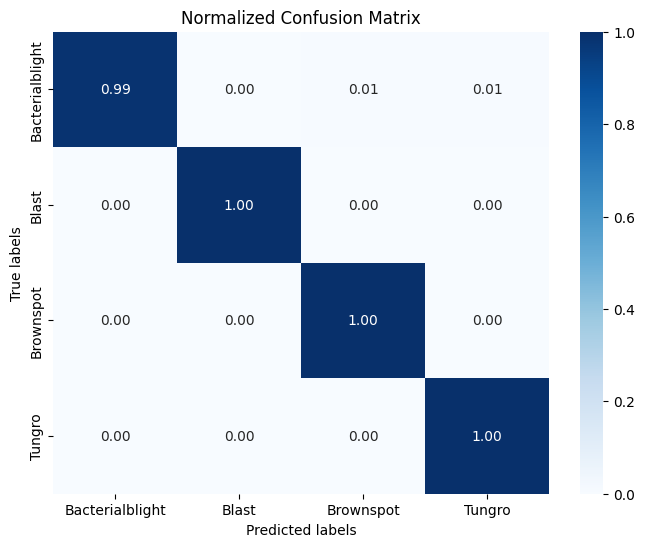

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
predicted_labels = np.argmax(model.predict(test_images), axis=-1)

# Create confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure for the plot
plt.figure(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()


In [39]:
from sklearn.metrics import classification_report

# Generate classification report
target_names = class_names  # Use the class names as target names
report = classification_report(test_labels, predicted_labels, target_names=target_names)

# Print the classification report
print("Classification Report:\n", report)


Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       1.00      0.99      0.99       170
          Blast       1.00      1.00      1.00       162
      Brownspot       0.99      1.00      1.00       164
         Tungro       0.99      1.00      1.00       144

       accuracy                           1.00       640
      macro avg       1.00      1.00      1.00       640
   weighted avg       1.00      1.00      1.00       640

